In [1]:
# Import relevent modules
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         238 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0        conda-forge
    geopy:         1.20.0-py_0      conda-forge

The following pac

In [2]:
# Pull dataset from NYU repository
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
# Load json data into newyork_data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
# Define neighborhood data
neighborhoods_data = newyork_data['features']

In [5]:
# Building pandas dataframe for NYC
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
# Filtering to just Manhattan neighborhoods
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [7]:
# Exploratory map of New York Neighborhoods
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [8]:
# Foursquare API access information
CLIENT_ID = 'CXKBFOT0NES1BWKP2254OD1RN1I2OSKZSV35NAK2V2OUJRIS' # your Foursquare ID
CLIENT_SECRET = 'YPICYNAIJBOVYXZTXNA2UB3K2Z1T1CR2NHDMM1NHHB32TURO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=CXKBFOT0NES1BWKP2254OD1RN1I2OSKZSV35NAK2V2OUJRIS&client_secret=YPICYNAIJBOVYXZTXNA2UB3K2Z1T1CR2NHDMM1NHHB32TURO&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

In [9]:
# Pulling Foursquare data for Manhattan
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
# Identify Manhattan venues
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )



Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [11]:
# Pull data from Foursquare
results = requests.get(url).json()

In [12]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Ski Shop,Smoke Shop

In [13]:
onehot_categories_list = list(manhattan_onehot.columns)

In [14]:
# Define restaurants - for this project, a restaurant is a place one would go to primarily dine.
# Bars and cafes, for example, are exluded, even if they may serve some food.
onehot_restaurants_list =  ['Afghan Restaurant','African Restaurant','American Restaurant','Arepa Restaurant','Argentinian Restaurant','Asian Restaurant','Australian Restaurant','Austrian Restaurant','BBQ Joint','Bagel Shop','Bistro','Brazilian Restaurant','Breakfast Spot','Burger Joint','Burrito Place','Cafeteria','Café','Cajun / Creole Restaurant','Cambodian Restaurant','Caribbean Restaurant','Caucasian Restaurant','Chinese Restaurant','College Cafeteria','Comfort Food Restaurant','Creperie','Cuban Restaurant','Cupcake Shop','Czech Restaurant','Dessert Shop','Dim Sum Restaurant','Diner','Donut Shop','Dumpling Restaurant','Eastern European Restaurant','Empanada Restaurant','English Restaurant','Ethiopian Restaurant','Falafel Restaurant','Fast Food Restaurant','Filipino Restaurant','Food Court','Food Stand','Food Truck','French Restaurant','Fried Chicken Joint','Frozen Yogurt Shop','Gastropub','German Restaurant','Greek Restaurant','Hawaiian Restaurant','Health & Beauty Service','Himalayan Restaurant','Hot Dog Joint','Hotpot Restaurant','Ice Cream Shop','Indian Restaurant','Israeli Restaurant','Italian Restaurant','Japanese Curry Restaurant','Japanese Restaurant','Jewish Restaurant','Kebab Restaurant','Korean Restaurant','Kosher Restaurant','Latin American Restaurant','Lebanese Restaurant','Malay Restaurant','Mediterranean Restaurant','Mexican Restaurant','Middle Eastern Restaurant','Modern European Restaurant','Molecular Gastronomy Restaurant','Moroccan Restaurant','New American Restaurant','Noodle House','Paella Restaurant','Pakistani Restaurant','Persian Restaurant','Peruvian Restaurant','Pizza Place','Poke Place','Ramen Restaurant','Restaurant','Russian Restaurant','Salad Place','Sandwich Place','Scandinavian Restaurant','Seafood Restaurant','Shanghai Restaurant','Soba Restaurant','Soup Place','South American Restaurant','South Indian Restaurant','Southern / Soul Food Restaurant','Spanish Restaurant','Steakhouse','Sushi Restaurant','Swiss Restaurant','Szechuan Restaurant','Taco Place','Taiwanese Restaurant','Tapas Restaurant','Thai Restaurant','Turkish Restaurant','Udon Restaurant','Vegetarian / Vegan Restaurant','Venezuelan Restaurant','Vietnamese Restaurant','Wings Joint']

In [15]:
manhattan_restaurants = manhattan_onehot[['Neighborhood','Afghan Restaurant', 'African Restaurant', 'American Restaurant', 'Arepa Restaurant', 'Argentinian Restaurant', 'Asian Restaurant', 'Australian Restaurant', 'Austrian Restaurant', 'BBQ Joint', 'Bagel Shop', 'Bistro', 'Brazilian Restaurant', 'Breakfast Spot', 'Burger Joint', 'Burrito Place', 'Cafeteria', 'Café', 'Cajun / Creole Restaurant', 'Cambodian Restaurant', 'Caribbean Restaurant', 'Caucasian Restaurant', 'Chinese Restaurant', 'College Cafeteria', 'Comfort Food Restaurant', 'Creperie', 'Cuban Restaurant', 'Cupcake Shop', 'Czech Restaurant', 'Dessert Shop', 'Dim Sum Restaurant', 'Diner', 'Donut Shop', 'Dumpling Restaurant', 'Eastern European Restaurant', 'Empanada Restaurant', 'English Restaurant', 'Ethiopian Restaurant', 'Falafel Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant', 'Food Court', 'Food Stand', 'Food Truck', 'French Restaurant', 'Fried Chicken Joint', 'Frozen Yogurt Shop', 'Gastropub', 'German Restaurant', 'Greek Restaurant', 'Hawaiian Restaurant', 'Health & Beauty Service', 'Himalayan Restaurant', 'Hot Dog Joint', 'Hotpot Restaurant', 'Ice Cream Shop', 'Indian Restaurant', 'Israeli Restaurant', 'Italian Restaurant', 'Japanese Curry Restaurant', 'Japanese Restaurant', 'Jewish Restaurant', 'Kebab Restaurant', 'Korean Restaurant', 'Kosher Restaurant', 'Latin American Restaurant', 'Lebanese Restaurant', 'Malay Restaurant', 'Mediterranean Restaurant', 'Mexican Restaurant', 'Middle Eastern Restaurant', 'Modern European Restaurant', 'Molecular Gastronomy Restaurant', 'Moroccan Restaurant', 'New American Restaurant', 'Noodle House', 'Paella Restaurant', 'Pakistani Restaurant', 'Persian Restaurant', 'Peruvian Restaurant', 'Pizza Place', 'Poke Place', 'Ramen Restaurant', 'Restaurant', 'Russian Restaurant', 'Salad Place', 'Sandwich Place', 'Scandinavian Restaurant', 'Seafood Restaurant', 'Shanghai Restaurant', 'Soba Restaurant', 'Soup Place', 'South American Restaurant', 'South Indian Restaurant', 'Southern / Soul Food Restaurant', 'Spanish Restaurant', 'Steakhouse', 'Sushi Restaurant', 'Swiss Restaurant', 'Szechuan Restaurant', 'Taco Place', 'Taiwanese Restaurant', 'Tapas Restaurant', 'Thai Restaurant', 'Turkish Restaurant', 'Udon Restaurant', 'Vegetarian / Vegan Restaurant', 'Venezuelan Restaurant', 'Vietnamese Restaurant', 'Wings Joint']]
manhattan_restaurants.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,College Cafeteria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Cupcake Shop,Czech Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Health & Beauty Service,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# Grouping rows by neighborhood
manhattan_grouped = manhattan_restaurants.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,College Cafeteria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Cupcake Shop,Czech Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Health & Beauty Service,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Battery Park City,0.0,0.000000,0.010101,0.0,0.0,0.00,0.0,0.00,0.020202,0.000000,0.010101,0.0,0.00,0.010101,0.010101,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.010101,0.0,0.0,0.00,0.0,0.010101,0.0,0.010101,0.00,0.0,0.010101,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.020202,0.0,0.010101,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.020202,0.00,0.00,0.020202,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.010101,0.010101,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.020202,0.00,0.00,0.00,0.0,0.00,0.020202,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,0.010101,0.010101,0.0,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.00,0.0,0.00,0.0
1,Carnegie Hill,0.0,0.000000,0.010000,0.0,0.0,0.00,0.0,0.00,0.000000,0.010000,0.000000,0.0,0.01,0.010000,0.000000,0.000000,0.040000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,0.01,0.0,0.000000,0.0,0.010000,0.030000,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.01,0.00,0.000000,0.02,0.00,0.020000,0.0,0.03,0.0,0.0,0.00,0.01,0.0,0.0,0.00,0.010000,0.010000,0.0,0.0,0.0,0.0,0.01,0.00,0.00,0.0,0.0,0.0,0.060000,0.00,0.01,0.01,0.0,0.01,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.010000,0.0,0.0,0.01,0.00,0.000000,0.01,0.0,0.0,0.01,0.0,0.02,0.0
2,Central Harlem,0.0,0.044444,0.044444,0.0,0.0,0.00,0.0,0.00,0.022222,0.022222,0.000000,0.0,0.00,0.000000,0.000000,0.022222,0.022222,0.0,0.0,0.022222,0.0,0.044444,0.0,0.0,0.00,0.0,0.000000,0.0,0.022222,0.00,0.0,0.000000,0.00,0.0,0.0,0.00,0.022222,0.0,0.00,0.0,0.000000,0.0,0.022222,0.044444,0.022222,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.000000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.022222,0.00,0.00,0.00,0.0,0.00,0.000000,0.0,0.044444,0.00,0.0,0.0,0.0,0.0,0.022222,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.022222,0.00,0.0,0.0,0.00,0.0,0.00,0.0
3,Chelsea,0.0,0.000000,0.030000,0.0,0.0,0.01,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.01,0.000000,0.000000,

In [17]:
# Qualifying all Mexican food (categories of "Burrito Place", "Mexican Restaurant", and "Taco Place")
manhattan_grouped['Total'] = manhattan_grouped.sum(axis=1)
manhattan_grouped['Mexican'] = manhattan_grouped[['Burrito Place', 'Mexican Restaurant', 'Taco Place']].sum(axis=1)
manhattan_grouped['% Mexican'] = manhattan_grouped['Mexican'] / manhattan_grouped['Total']
manhattan_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,College Cafeteria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Cupcake Shop,Czech Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Health & Beauty Service,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Total,Mexican,% Mexican
0,Battery Park City,0.0,0.000000,0.010101,0.0,0.0,0.00,0.0,0.00,0.020202,0.000000,0.010101,0.0,0.00,0.010101,0.010101,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.010101,0.0,0.0,0.00,0.0,0.010101,0.0,0.010101,0.00,0.0,0.010101,0.00,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.020202,0.0,0.010101,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.020202,0.00,0.00,0.020202,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.010101,0.010101,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.020202,0.00,0.00,0.00,0.0,0.00,0.020202,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,0.010101,0.010101,0.0,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.252525,0.020202,0.080000
1,Carnegie Hill,0.0,0.000000,0.010000,0.0,0.0,0.00,0.0,0.00,0.000000,0.010000,0.000000,0.0,0.01,0.010000,0.000000,0.000000,0.040000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,0.01,0.0,0.000000,0.0,0.010000,0.030000,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.01,0.00,0.000000,0.02,0.00,0.020000,0.0,0.03,0.0,0.0,0.00,0.01,0.0,0.0,0.00,0.010000,0.010000,0.0,0.0,0.0,0.0,0.01,0.00,0.00,0.0,0.0,0.0,0.060000,0.00,0.01,0.01,0.0,0.01,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.010000,0.0,0.0,0.01,0.00,0.000000,0.01,0.0,0.0,0.01,0.0,0.02,0.0,0.400000,0.020000,0.050000
2,Central Harlem,0.0,0.044444,0.044444,0.0,0.0,0.00,0.0,0.00,0.022222,0.022222,0.000000,0.0,0.00,0.000000,0.000000,0.022222,0.022222,0.0,0.0,0.022222,0.0,0.044444,0.0,0.0,0.00,0.0,0.000000,0.0,0.022222,0.00,0.0,0.000000,0.00,0.0,0.0,0.00,0.022222,0.0,0.00,0.0,0.000000,0.0,0.022222,0.044444,0.022222,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.000000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.022222,0.00,0.00,0.00,0.0,0.00,0.000000,0.0,0.044444,0.00,0.0,0.0,0.0,0.0,0.022222,0.00,0.000000,0.000000,0.0,0.0,0.00,0.00,0.022222,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.488889,0.000000,0.000000
3,C

In [18]:
# Remove individual restaurant data
mexican_restaurants = manhattan_grouped[['Neighborhood','% Mexican']]
mexican_restaurants['% Mexican'] = mexican_restaurants['% Mexican']*100
mexican_restaurants = pd.DataFrame(mexican_restaurants)
mexican_restaurants.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,% Mexican
0,Battery Park City,8.000000
1,Carnegie Hill,5.000000
2,Central Harlem,0.000000
3,Chelsea,4.761905
4,Chinatown,2.083333


In [19]:
# Import Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

In [20]:
mexican_restaurants.describe()

,% Mexican
count,40.000000
mean,5.132075
std,5.656830
min,0.000000
25%,1.388889
50%,3.892668
75%,6.965488
max,28.571429


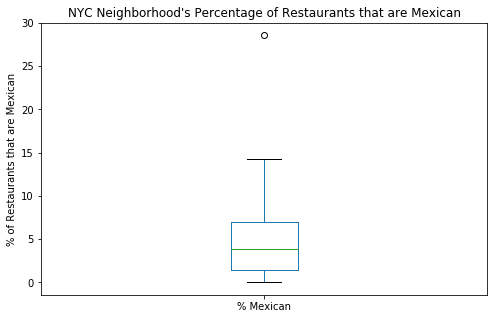

In [21]:
mexican_restaurants['% Mexican'].plot(kind='box', figsize=(8, 5))

plt.title("NYC Neighborhood's Percentage of Restaurants that are Mexican")
plt.xlabel('')
plt.ylabel('% of Restaurants that are Mexican')

plt.show()

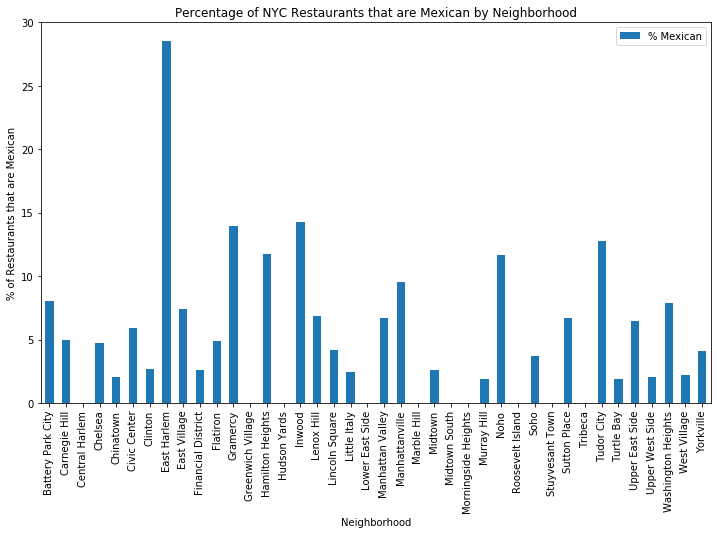

In [22]:
# Show data as bar graph
mexican_restaurants_bar = mexican_restaurants.set_index('Neighborhood')
mexican_restaurants_bar.plot(kind='bar', figsize=(12, 7), rot=90)

plt.xlabel('Neighborhood')
plt.ylabel('% of Restaurants that are Mexican')
plt.title('Percentage of NYC Restaurants that are Mexican by Neighborhood')

plt.show()

In [23]:
# Show neighborhoods with zero Mexican restaurants
mexican_restaurants_bar.loc[mexican_restaurants_bar['% Mexican'] == 0]

,% Mexican
Neighborhood,
Central Harlem,0.0
Greenwich Village,0.0
Hudson Yards,0.0
Lower East Side,0.0
Marble Hill,0.0
Midtown South,0.0
Morningside Heights,0.0
Roosevelt Island,0.0
Stuyvesant Town,0.0


### There are 10 neighborhoods currently without any Mexican restaurants

In [24]:
# Merge neighborhood data with percentage of Mexican restaurants 
manhattan_neighborhoods_ = manhattan_data.drop('Borough', axis = 1)
manhattan_neighborhoods_ = manhattan_neighborhoods_.set_index('Neighborhood')

In [92]:
df_merged = manhattan_neighborhoods_.join(mexican_restaurants_bar, how='outer')
df_merged = df_merged.reset_index()
df_merged.head()

,Neighborhood,Latitude,Longitude,% Mexican
0,Battery Park City,40.711932,-74.016869,8.000000
1,Carnegie Hill,40.782683,-73.953256,5.000000
2,Central Harlem,40.815976,-73.943211,0.000000
3,Chelsea,40.744035,-74.003116,4.761905
4,Chinatown,40.715618,-73.994279,2.083333


In [93]:
# Binning
bins = [-0.1,0.01,100]
labels = [0,1]
df_merged['binned'] = pd.cut(df_merged['% Mexican'], bins=bins, labels=labels)
df_merged.head()

,Neighborhood,Latitude,Longitude,% Mexican,binned
0,Battery Park City,40.711932,-74.016869,8.000000,1
1,Carnegie Hill,40.782683,-73.953256,5.000000,1
2,Central Harlem,40.815976,-73.943211,0.000000,0
3,Chelsea,40.744035,-74.003116,4.761905,1
4,Chinatown,40.715618,-73.994279,2.083333,1


In [94]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

clusters=2

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['binned']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters